In [21]:
# Module Importations
import matplotlib.pylab as plt
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import tensorflow.keras as keras
import types
import yellowbrick
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [22]:
# Custom Modules
from Source.Data import ntfp_dataset_import as data_load
from Source.Data import ntfp_split_data as split_data
from Source.Model import ntfp_keras_helpers as keras_helpers
from Source.Model import ntfp_model_evaluation as evaluation
from Source.Model import ntfp_tensorboard_helpers as tb_helpers
from Source.Visualisation import figs_helper

In [23]:
# Module versioning information (WIP)
def yield_version_info():

    # Iterate over items in workspace
    for name, val in globals().items():

        # Try to return version if module type
        if isinstance(val, types.ModuleType):
            try:
                yield val.__name__, val.__version__
            except:
                yield val.__name__, "No version information"

list(yield_version_info())

[('builtins', 'No version information'),
 ('builtins', 'No version information'),
 ('os', 'No version information'),
 ('sys', 'No version information'),
 ('matplotlib.pylab', '1.19.4'),
 ('numpy', '1.19.4'),
 ('sklearn', '0.22.2.post1'),
 ('tensorflow', '2.4.1'),
 ('tensorflow.keras', '2.4.0'),
 ('types', 'No version information'),
 ('yellowbrick', '1.2'),
 ('Source.Data.ntfp_dataset_import', 'No version information'),
 ('Source.Data.ntfp_split_data', 'No version information'),
 ('Source.Model.ntfp_keras_helpers', 'No version information'),
 ('Source.Model.ntfp_model_evaluation', 'No version information'),
 ('Source.Model.ntfp_tensorboard_helpers', 'No version information'),
 ('Source.Visualisation.figs_helper', 'No version information')]

In [24]:
# Constants
SAVE_FIGS = False
TRAIN_BASE_MODEL = False
TRAIN_OPT_MODEL = True

In [25]:
# Load Dataset (Use set from previous ML investigation)
filename = 'rul_dataset_full_preprocessed.pkl'
rul_df = data_load.load_pickled_data(filename)

print(rul_df)

Loading pickled dataframe started ...
Loading pickled dataframe complete ...
          Sn_03  Sn_11    Sn_14   Sn_15  Sn_16    RUL
Engine                                               
1       1589.70  47.47  8138.62  8.4195   0.03 -191.0
1       1591.82  47.49  8131.49  8.4318   0.03 -190.0
1       1587.99  47.27  8133.23  8.4178   0.03 -189.0
1       1582.79  47.13  8133.83  8.3682   0.03 -188.0
1       1582.85  47.28  8133.80  8.4294   0.03 -187.0
...         ...    ...      ...     ...    ...    ...
709     1516.36  46.08  8185.69  8.4541   0.03   -4.0
709     1598.92  48.04  8185.47  8.2221   0.03   -3.0
709     1607.72  48.24  8193.94  8.2525   0.03   -2.0
709     1381.29  42.53  8125.64  9.0515   0.02   -1.0
709     1369.75  42.60  8144.33  9.1207   0.02    0.0

[160359 rows x 6 columns]


In [26]:
# Split data into training and evaluation sets
training_set, evaluation_set = split_data.split_train_eval(rul_df, 0.2)

Original Data Items: 160359
Training Data Items: 128288
Evaluation Data Items: 32071


In [27]:
# Create RUL Target Dataset

# Training Set as Array
rul_training_data = training_set.drop('RUL', axis = 1).values
rul_training_label = training_set['RUL'].copy().values

print(rul_training_data.shape, rul_training_label.shape)

# Evaluation Set as Array
rul_eval_data = evaluation_set.drop('RUL', axis = 1).values
rul_eval_label = evaluation_set['RUL'].copy().values

print(rul_eval_data.shape, rul_eval_label.shape)

(128288, 5) (128288,)
(32071, 5) (32071,)


In [28]:
# Create train and test arrays
X_train, X_test, y_train, y_test = train_test_split(rul_training_data, rul_training_label, test_size = 0.2, random_state = 0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(102630, 5) (25658, 5)
(102630,) (25658,)


In [29]:
# Initial MLP (Target - RUL)

if TRAIN_BASE_MODEL == True:
    # Clear existing models
    keras.backend.clear_session()

    # Build model
    model = keras_helpers.build_multilayer_perceptron()

    # Name model
    model_type = "MLP_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tb_helpers.get_run_logdir()
    print(tb_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    model.fit(X_train, y_train, epochs = 20, validation_data =(X_test, y_test), callbacks =[checkpoint_cb, earlystop_cb, tensorboard_cb])

In [30]:
# Evaluate MLP Model

if TRAIN_BASE_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_25-09_40_38.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
MLP_RUL rmse (Eval): 83.42802948096896
MLP_RUL mae (Eval): 66.76176571463152
MLP_RUL r2 (Eval): -0.0013836768782695685


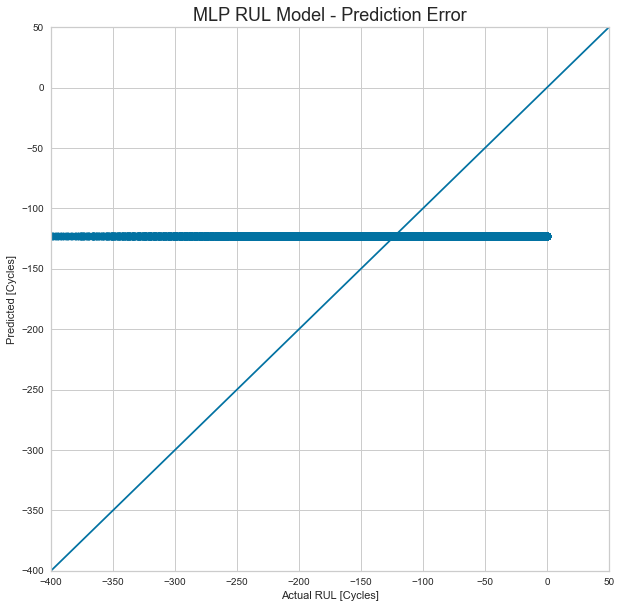

In [31]:
# Visualise Prediction Error (MLP - RUL)
if TRAIN_BASE_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_25-09_42_11.h5'

# Load model
model = keras.models.load_model(filepath_full)
rul_prediction = model.predict(rul_eval_data).flatten()

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.scatter(rul_eval_label, rul_prediction)

# Set figure styling
plt.title('MLP RUL Model - Prediction Error', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Actual RUL [Cycles]')
plt.ylabel('Predicted [Cycles]')
lims = [-400, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Prediction_Err'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

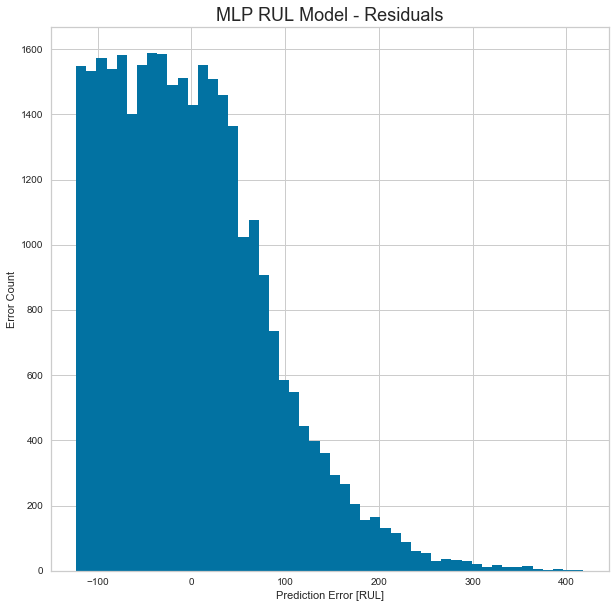

In [32]:
# Visualise Residual Error (MLP - RUL)
if TRAIN_BASE_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_RUL_2021_03_16-16_12_43.h5'

# Load model
model = keras.models.load_model(filepath_full)
error = rul_prediction - rul_eval_label

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.hist(error, bins = 50)

# Set figure styling
plt.title('MLP RUL Model - Residuals', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Prediction Error [RUL]')
plt.ylabel('Error Count')

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_RUL_Residuals'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

In [13]:
# Coarse - Optimised MLP (Target - RUL)

if TRAIN_OPT_MODEL == True:
    # Clear existing models
    keras.backend.clear_session()

    # Establish parameter distribution for tuning
    param_distribs = {
        "n_hidden": [2, 4, 8, 16],
        "n_neurons": [5, 10, 20, 40, 60, 80, 100],
        "learning_rate": [1e-2, 1e-3, 1e-4],
    }

    # Build model
    wrapped_model = keras_helpers.wrap_model()

    # Initialise random search
    rnd_search_cv = RandomizedSearchCV(wrapped_model, param_distribs, n_iter = 10, cv = 3)

    # Name model
    model_type = "MLP_Opt_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tb_helpers.get_run_logdir()
    print(tb_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    rnd_search_cv.fit(X_train, y_train, epochs = 100, validation_data =(X_test, y_test), callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb], verbose = 1)

In [14]:
# Evaluate MLP Model
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_16-16_12_59.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_211 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_212 (Dense)            (None, 1)                 101       
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
_________________________________________________________________
MLP_RUL rmse (Eval): 2798.9411037703803
MLP_RUL mae (Eval): 2797.5308497954247
MLP_RUL r2 (Eval): -1126.1041685253447


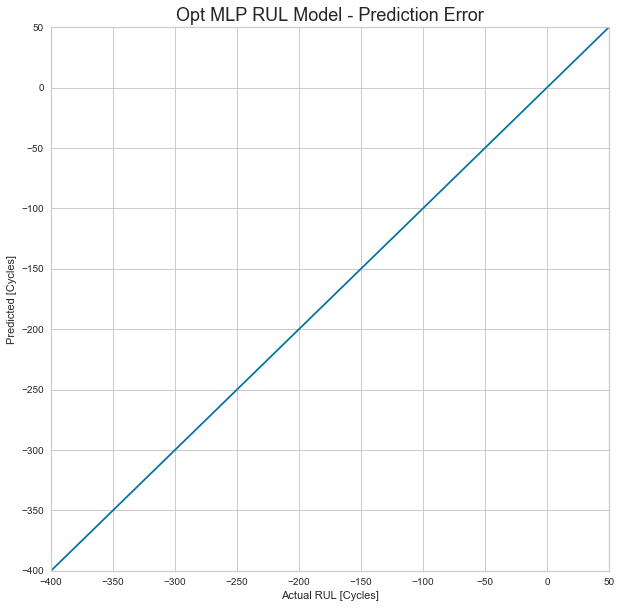

In [15]:
# Visualise Prediction Error (MLP Opt - RUL)
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_16-16_12_59.h5'

# Load model
model = keras.models.load_model(filepath_full)
rul_prediction = model.predict(rul_eval_data).flatten()

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.scatter(rul_eval_label, rul_prediction)

# Set figure styling
plt.title('Opt MLP RUL Model - Prediction Error', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Actual RUL [Cycles]')
plt.ylabel('Predicted [Cycles]')
lims = [-400, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_Opt_RUL_Prediction_Err'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

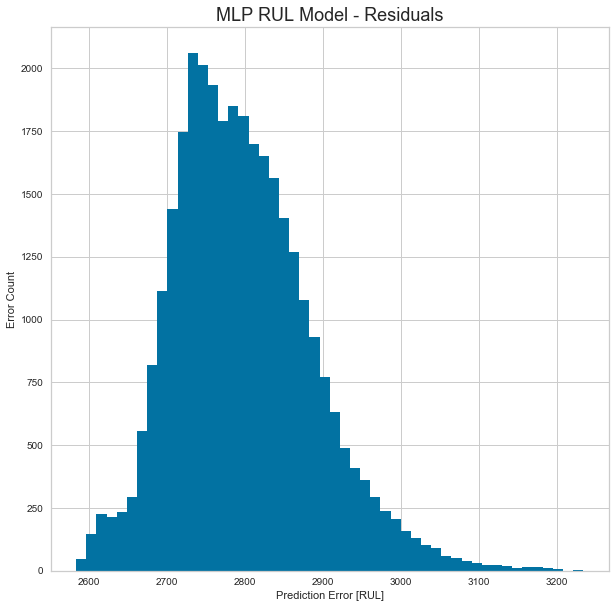

In [16]:
# Visualise Residual Error (MLP - RUL)
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_16-16_12_59.h5'

# Load model
model = keras.models.load_model(filepath_full)
error = rul_prediction - rul_eval_label

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.hist(error, bins = 50)

# Set figure styling
plt.title('MLP RUL Model - Residuals', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Prediction Error [RUL]')
plt.ylabel('Error Count')

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_Opt_RUL_Residuals'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

In [17]:
# Fine - Optimised MLP (Target - RUL)

if TRAIN_OPT_MODEL == True:
    # Clear existing models
    keras.backend.clear_session()

    # Establish parameter distribution for tuning
    param_distribs = {
        "n_hidden": [1, 2, 3, 4],
        "n_neurons": [80, 90, 100, 110, 120],
        "learning_rate": [1e-3, 1e-4, 1e-5],
    }

    # Build model
    wrapped_model = keras_helpers.wrap_model()

    # Initialise random search
    rnd_search_cv = RandomizedSearchCV(wrapped_model, param_distribs, n_iter = 10, cv = 3)

    # Name model
    model_type = "MLP_Opt_RUL"
    model_id = keras_helpers.name_model(model_type)
    filepath_full = keras_helpers.make_save_string(model_id)

    # Set save and earlystop callbacks
    earlystop_cb = keras.callbacks.EarlyStopping(patience = 5)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = filepath_full, save_best_only = True)

    # Set TensorBoard callback for logging
    tb_logdir = tb_helpers.get_run_logdir()
    print(tb_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(tb_logdir)

    # Train model
    rnd_search_cv.fit(X_train, y_train, epochs = 10000, validation_data =(X_test, y_test), callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb], verbose = 1)

In [18]:
# Evaluate MLP Model

if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_16-16_19_30.h5'

# Load model
model = keras.models.load_model(filepath_full)

# Summarise model
model.summary()

# Make predictions
rul_pred_eval = model.predict(rul_eval_data)

# Determine model prediction stats
model_name = "MLP_RUL"
evaluation.evaluate_model(model_name, rul_eval_label, rul_pred_eval)

# Calculate indicative accuracy
rmse, mae, r2 = evaluation.return_model_evaluation_stats(rul_eval_label, rul_pred_eval)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 110)               660       
_________________________________________________________________
dense_9 (Dense)              (None, 110)               12210     
_________________________________________________________________
dense_10 (Dense)             (None, 110)               12210     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 111       
Total params: 25,191
Trainable params: 25,191
Non-trainable params: 0
_________________________________________________________________
MLP_RUL rmse (Eval): 991.9138509251588
MLP_RUL mae (Eval): 983.4227554907927
MLP_RUL r2 (Eval): -140.55474946282848


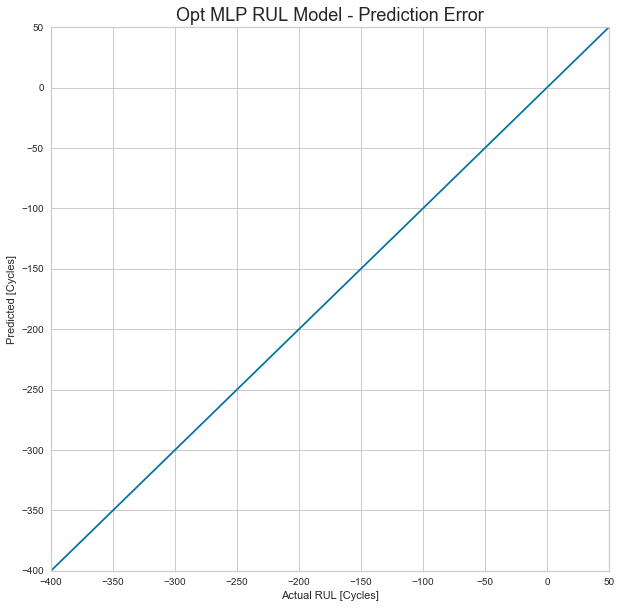

In [19]:
# Visualise Prediction Error (MLP Opt - RUL)
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_16-16_19_30.h5'

# Load model
model = keras.models.load_model(filepath_full)
rul_prediction = model.predict(rul_eval_data).flatten()

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.scatter(rul_eval_label, rul_prediction)

# Set figure styling
plt.title('Opt MLP RUL Model - Prediction Error', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Actual RUL [Cycles]')
plt.ylabel('Predicted [Cycles]')
lims = [-400, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_Opt+_RUL_Prediction_Err'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)

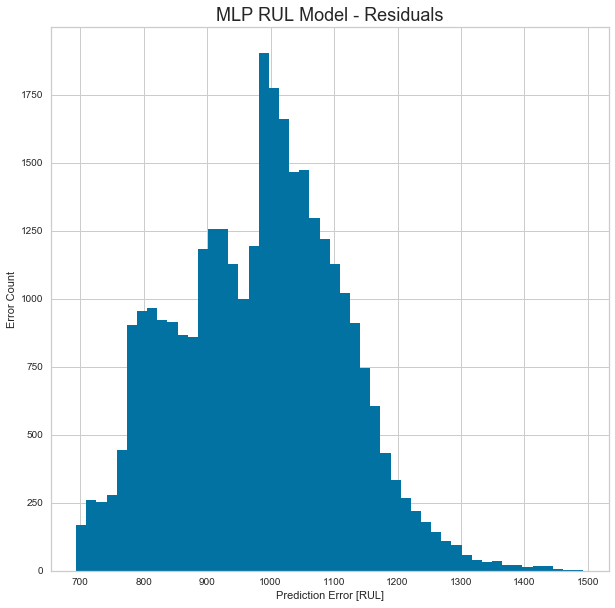

In [20]:
# Visualise Residual Error (MLP - RUL)
if TRAIN_OPT_MODEL == False:
    filepath_full = r'C:\Developer\nasa-turbofan-failure-prediction\Models\PM_MLP_Opt_RUL_2021_03_16-16_19_30.h5'

# Load model
model = keras.models.load_model(filepath_full)
error = rul_prediction - rul_eval_label

# Plot predicted and actual data
plt.figure(figsize = (10, 10))
plt.hist(error, bins = 50)

# Set figure styling
plt.title('MLP RUL Model - Residuals', fontsize = figs_helper.TITLE_FONTSIZE)
plt.xlabel('Prediction Error [RUL]')
plt.ylabel('Error Count')

# Save fig
if SAVE_FIGS == True: 
    name = 'MLP_Opt+_RUL_Residuals'
    save_string = figs_helper.generate_fig_save_string(name)
    plt.savefig(save_string, format = 'png', dpi = 600)